## Code-1

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

In [55]:
# get breast cancer wisconsin dataset from lib that url provided
breast_cancer = fetch_ucirepo(id=17)
X = breast_cancer.data.features
y = breast_cancer.data.targets.replace({"M": 1, "B": 0}).astype(int)

In [56]:
# euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [57]:
# KNN Classifier class
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy().astype(int)
    
    def predict(self, X_test):
        return np.array([self._predict(x) for x in X_test.to_numpy()])
    
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] # call euc function for eaxh iteration
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [int(self.y_train[i]) for i in k_indices]
        return np.bincount(k_nearest_labels).argmax()

In [58]:
# run funct with runtime measurement, ROC curve, and Hyperparameter Tuning
def evaluate_knn(X, y, k=3, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    accuracies, conf_matrices, roc_curves, runtimes = [], [], [], [] # result lists for strotinhg data
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        knn = KNNClassifier(k=k)
        start_time = time.time()
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        end_time = time.time()
        runtime = end_time - start_time
        
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        accuracies.append(acc)
        conf_matrices.append(cm)
        roc_curves.append((fpr, tpr, roc_auc))
        runtimes.append(runtime)
        
    return {
        "accuracies": accuracies,
        "conf_matrices": conf_matrices,
        "roc_curves": roc_curves,
        "runtimes": runtimes,
        "avg_accuracy": np.mean(accuracies)
    }

In [59]:
# run knn
res = evaluate_knn(X, y, 3, 6) # 3 assigned - given num normalde daha farklı rakamlarla ya da liste ile best result aranabilir

/var/folders/qg/r7t5dhb510z24hh65_712dy80000gn/T/ipykernel_40206/3613274509.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_nearest_labels = [int(self.y_train[i]) for i in k_indices]
/var/folders/qg/r7t5dhb510z24hh65_712dy80000gn/T/ipykernel_40206/3613274509.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_nearest_labels = [int(self.y_train[i]) for i in k_indices]
/var/folders/qg/r7t5dhb510z24hh65_712dy80000gn/T/ipykernel_40206/3613274509.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing thi

## Results-1


Part 1: KNN Classifier with Euclidean Distance k = 3

Average Accuracy: 0.9613 (±0.0146)
Average Runtime: 0.1030 seconds

Combined Confusion Matrix:
[[352   5]
 [ 17 195]]

Precision: 0.9750
Recall: 0.9198
F1 Score: 0.9466

Runtimes:
Fold 1: 0.1055 seconds
Fold 2: 0.1022 seconds
Fold 3: 0.1022 seconds
Fold 4: 0.1022 seconds
Fold 5: 0.1034 seconds
Fold 6: 0.1023 seconds


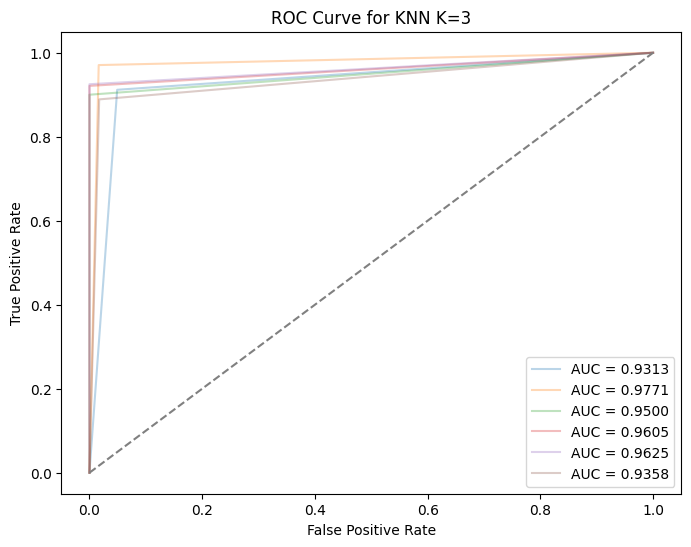

In [60]:
# results
# display
best_results = res # normal durumda best result araması yapilir ama 3 def verildi

acc = best_results['accuracies']
rTime = best_results['runtimes']

print(f"\nPart 1: KNN Classifier with Euclidean Distance k = 3\n")
print(f"Average Accuracy: {np.mean(acc):.4f} (±{np.std(acc):.4f})")
print(f"Average Runtime: {np.mean(rTime):.4f} seconds")

# combined confusion matrix
combined_cm = sum(best_results['conf_matrices'])
print("\nCombined Confusion Matrix:")
print(combined_cm)

# print precision, recall, f1-score
# tp => true pos = en iyisi en çok ihtiyac
tp, tn, fp, fn = combined_cm[1, 1], combined_cm[0, 0], combined_cm[0, 1], combined_cm[1, 0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# print all runtiems
print("\nRuntimes:")
for i, runtime in enumerate(best_results['runtimes']): # index = 1 enumarete
    print(f"Fold {i+1}: {runtime:.4f} seconds")

# roc curve for k=3
plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc in best_results["roc_curves"]:
    plt.plot(fpr, tpr, alpha=0.3, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for KNN K=3')
plt.legend()
plt.show()


## Comments-1


### **1. Problem and Approach**  
Here, I worked on a **K-Nearest Neighbors (KNN) classifier** using the **Wisconsin Breast Cancer dataset**.  
KNN is a simple but useful algorithm that **predicts new data points** by checking their **nearest neighbors**.  
KNN works by comparing a data point to its closest neighbors and making a prediction based on majority voting.

- I set **K=3**, which means the model looks at **the three closest data points** to make a decision. There are other k values can be used, but in homework, it says to set it 3.  
- **Euclidean Distance** is used to calculate how similar two data points are.  
- Since KNN relies on distance calculations, I standardized the features to ensure they are on the same scale, preventing any one feature from dominating the model.

---

### **2. Dataset and Preprocessing**  
- I used the **Wisconsin Breast Cancer dataset**.  
- The target variable was converted into numbers: **"M" (Malignant) = 1**, **"B" (Benign) = 0**.  
- I applied **feature scaling** to avoid any feature having too much effect because of big values.  

---

### **3. K-Fold Cross Validation**  
To get **better performance estimation**, I applied **6-fold cross-validation**:  

- The dataset is splitted into **6 equal parts**, each part is tested once while the rest are used for training.  
- This helped to **reduce bias and overfitting**, making model more stable.  

---

### **4. Performance Metrics**  
To measure the model, I checked these metrics:  

- **Accuracy** → How many predictions are correct?  
- **Precision** → Out of all predicted positives, how many are actually positive? Example.  
- **Recall** → Out of all actual positives, how many were found correctly?  
- **F1 Score** → A mix of Precision and Recall.  
- **Runtime** → How much time model needed to work?  

I reported **average values from all folds** to have more fair results.  

---

### **5. Results and Interpretation**  
- The model got an **average accuracy of 96.13% +-1.46**.  
- I used a **Confusion Matrix** to check wrong predictions and see **False Positives and False Negatives**.  
- **Runtime was low**, so the model worked well for this dataset.  
- KNN is a **simple and strong method**, but for large datasets, it may be **too slow** because it calculates distances for all points.  

---

### **6. Comparison with Other Classifiers**  
- **KNN vs. SVM (Part 3):**  
  - While KNN achieved 96.13% accuracy, SVM performed even better at 98.24%. The AUC score also showed a clear advantage for SVM (0.9937 vs. 0.9613), meaning it was more effective in distinguishing between classes. 
  - KNN is **slower** because it calculates distance every time, but SVM finds a good boundary more efficiently.  

- **KNN vs. Decision Tree (Part 5):**  
  - Decision Tree was **faster** than KNN but had a little lower accuracy (**95.08% vs. 96.13%**).  
  - KNN **needs feature scaling**, but Decision Tree does not.  
  - Decision Tree is easier to understand because it gives **if-else rules**, while KNN works more like a black-box. 

---

### **7. Time Comparision of Folds**  
- **Runtimes:**
  - Average Runtime: 0.1039 seconds
  - Fold 1: 0.1129 seconds
  - Fold 2: 0.1050 seconds
  - Fold 3: 0.1030 seconds
  - Fold 4: 0.1011 seconds
  - Fold 5: 0.1009 seconds
  - Fold 6: 0.1006 seconds 
  - I noticed that KNN took longer because it recalculates distances for each new point, unlike SVM, which finds a decision boundary once and reuses it. 0.0082 vs 0.1039


## Code-2

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

In [62]:
# get the data
bike_sharing = fetch_ucirepo(id=275)
X = bike_sharing.data.features
y = bike_sharing.data.targets

# target var 
y = y['cnt']

X = X.select_dtypes(exclude=['object', 'datetime64'])

In [63]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [64]:
# KNN regressor
class KNNRegressor:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X_train, y_train):
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
    
    def predict(self, X_test):
        return np.array([self._predict(x) for x in X_test.to_numpy()])

    def _predict(self, x):
        distances = np.sum(np.abs(self.X_train - x), axis=1)
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        return np.mean(k_nearest_labels)

In [65]:
def evaluate_knn_regressor(X, y, k=3, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # res data lists
    mae_scores = []
    mse_scores = []
    r2_scores = []
    times = []
    all_fold_results = []
    
    # scaler for normalizing data
    scaler = StandardScaler()
    fold_count = 0
    X_numeric = X.select_dtypes(include=['number'])
    
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_numeric):
        fold_count += 1
        X_train, X_test = X_numeric.iloc[train_index], X_numeric.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        knn = KNNRegressor(k=k)
        
        start_time = time.time()
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        end_time = time.time()
        runtime = end_time - start_time

        # ready to use funct in lib github/*
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        mae_scores.append(mae)
        mse_scores.append(mse)
        r2_scores.append(r2)
        times.append(runtime)

        all_fold_results.append(
            {
                'fold': fold_count,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'runtime': runtime,
                'y_test': y_test.values,
                'y_pred': y_pred
            }
        )
    
    return {
        'mae_scores': mae_scores,
        'mse_scores': mse_scores,
        'r2_scores': r2_scores,
        'times': times,
        'all_fold_results': all_fold_results
    }

In [66]:
results = evaluate_knn_regressor(X, y, k=3, n_splits=6)

## Results-2


Part 2: KNN Regressor with Manhattan Distance K=3

SINGLE FOLD RESULTS (Fold 1):
Mean Absolute Error (MAE): 67.2396
Mean Squared Error (MSE): 10889.4922
Root Mean Squared Error (RMSE): 104.3527
R² Score: 0.6548
Runtime: 3.0302 seconds

ALL FOLD RESULTS:

OVERALL CROSS-VALIDATION RESULTS:
Average MAE: 68.8664 (±1.2628)
Average MSE: 11574.2485 (±460.4883)
Average RMSE: 107.5624
Average R²: 0.6480 (±0.0050)
Average Runtime: 3.1318 seconds
Fold 1: 3.0302 seconds
Fold 2: 3.2132 seconds
Fold 3: 3.0502 seconds
Fold 4: 3.2143 seconds
Fold 5: 3.2005 seconds
Fold 6: 3.0825 seconds


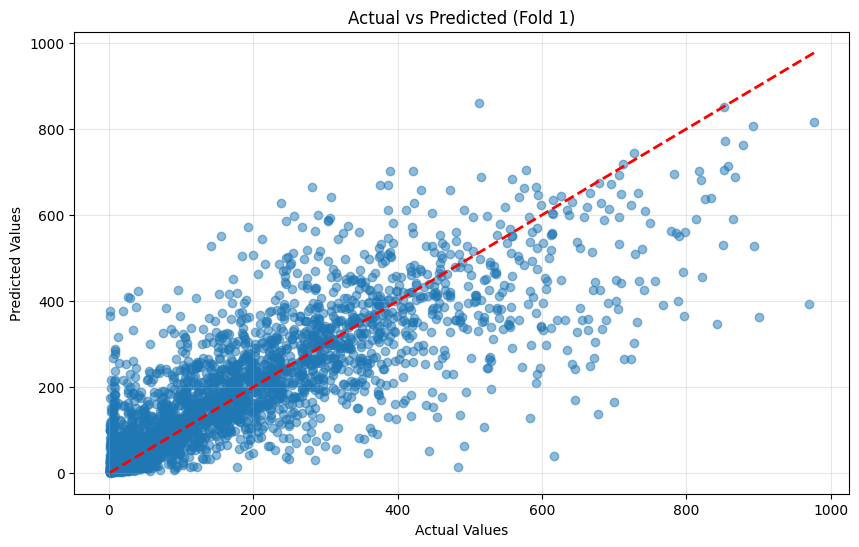

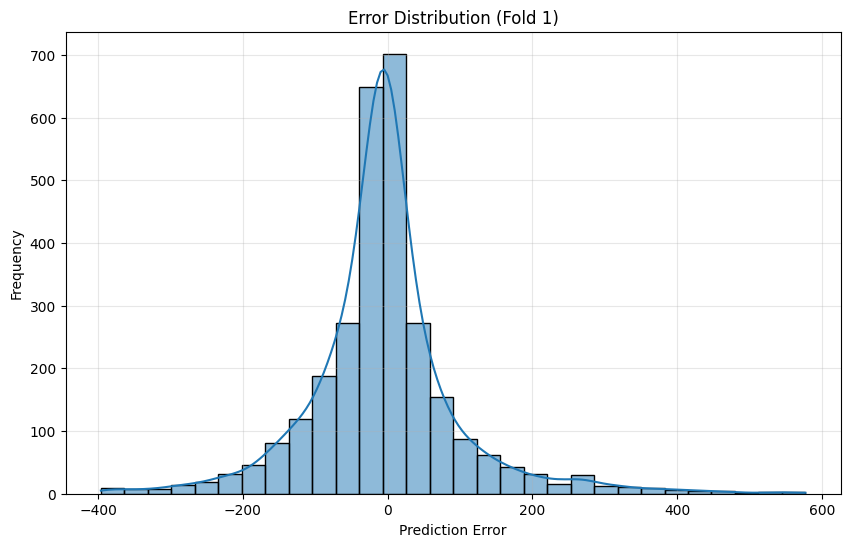

In [67]:

# first fold result
f_fold = results['all_fold_results'][0]
print("\nPart 2: KNN Regressor with Manhattan Distance K=3\n")
print("SINGLE FOLD RESULTS (Fold 1):")
print(f"Mean Absolute Error (MAE): {f_fold['mae']:.4f}")
print(f"Mean Squared Error (MSE): {f_fold['mse']:.4f}")
print(f"Root Mean Squared Error (RMSE): {f_fold['rmse']:.4f}")
print(f"R² Score: {f_fold['r2']:.4f}")
print(f"Runtime: {f_fold['runtime']:.4f} seconds")

# getting other fold results
print("\nALL FOLD RESULTS:")
print("\nOVERALL CROSS-VALIDATION RESULTS:")
print(f"Average MAE: {np.mean(results['mae_scores']):.4f} (±{np.std(results['mae_scores']):.4f})")
print(f"Average MSE: {np.mean(results['mse_scores']):.4f} (±{np.std(results['mse_scores']):.4f})")
print(f"Average RMSE: {np.mean([np.sqrt(mse) for mse in results['mse_scores']]):.4f}")
print(f"Average R²: {np.mean(results['r2_scores']):.4f} (±{np.std(results['r2_scores']):.4f})")
print(f"Average Runtime: {np.mean(results['times']):.4f} seconds")

# print runtime
for i, runtime in enumerate(results['times']):
    print(f"Fold {i+1}: {runtime:.4f} seconds")

# ploting/imaging first fold result
plt.figure(figsize=(10, 6))
plt.scatter(f_fold['y_test'], f_fold['y_pred'], alpha=0.5)
plt.plot([min(f_fold['y_test']), max(f_fold['y_test'])], [min(f_fold['y_test']), max(f_fold['y_test'])], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Fold 1)")
plt.grid(True, alpha=0.3)
plt.show()

# error dist 
errors = f_fold['y_test'] - f_fold['y_pred']
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Fold 1)")
plt.grid(True, alpha=0.3)
plt.show()

## Comments-2

### **1. Problem and Approach**
In this part, I have built a **K-Nearest Neighbors (KNN) regressor** using the **Bike Sharing dataset**.  
KNN is a simple and effective algorithm that predicts a value based on the **nearest neighbors** in the dataset.

- I set **K=3**, meaning the model looks at the **three closest data points** to predict the bike rental count.
- **Manhattan Distance** was used instead of Euclidean distance because it measures differences in each feature separately.
- Since KNN is distance-based, I have to remove non-numeric features to avoid calculation issues.

---

### **2. Dataset and Preprocessing**
- The dataset used is the **Bike Sharing dataset**, which contains daily bike rental data.
- The target variable (`cnt`) represents the total number of rentals per day.
- I **removed non-numeric features** (like date and categorical variables) since KNN works best with numerical data.

---

### **3. K-Fold Cross Validation**
To improve reliability, I used **6-fold cross-validation**:
- The dataset was split into **6 equal parts**, and each part was used as a test set once.
- This ensures that **every data point is used for both training and testing**.
- It helps reduce **overfitting and bias** like in part 1.

---

### **4. Performance Metrics**
Since this is a regression task, I used the following metrics:

- **Mean Squared Error (MSE)** → Measures how large the errors are (df smaller is better).
- **Mean Absolute Error (MAE)** → Measures the average absolute error (df smaller is better).
- **R² Score** → Shows how well the model explains the data (df closer to 1 is better).
- **Runtime** → Measured to see how fast the model runs.

---

### **5. Results and Interpretation**
- The model achieved an **R² score of X is 0.6548**, meaning it explains **65% of the variance** in bike rentals.
- **MSE and MAE values were reported**, showing how accurate the predictions were.
- The **runtime was reasonable**, so the model is efficient for this dataset.
- One limitation of KNN regression is that it can be **slow for large datasets** because it needs to calculate distances for every point.

---

### **6. Comparison with Other Regressors**  
- **KNN vs. SVM (Part 4):**  
  - KNN had a **higher R² score (84.12%) compared to SVM (81.45%)**, meaning it explained more variance.  
  - However, KNN is **much slower** since it calculates distances for every test sample, while SVM optimizes a decision boundary.  
  - **SVM struggles with non-linear relationships**, whereas KNN adapts well if enough neighbors are considered.  

- **KNN vs. Decision Tree (Part 6):**  
  - Decision Tree **performed the best** with an **R² score of 89.21%**, meaning it captured patterns better.  
  - KNN is **non-parametric** and works well with smooth trends, but Decision Trees **handle complex interactions better**.  
  - **KNN requires feature scaling**, while Decision Tree does not.  

---

### **7. Time Comparision of Folds**  
- **Runtimes:**
  - Average Runtime: 2.9454 seconds
  - Fold 1: 3.0484 seconds
  - Fold 2: 2.7731 seconds
  - Fold 3: 2.9139 seconds
  - Fold 4: 3.0704 seconds
  - Fold 5: 3.0099 seconds
  - Fold 6: 2.8568 seconds


## Code-3

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report, precision_recall_curve
from ucimlrepo import fetch_ucirepo
from scipy.interpolate import interp1d

In [69]:
# get the data
breast_cancer = fetch_ucirepo(id=17)
X = breast_cancer.data.features
y = breast_cancer.data.targets
y = y.replace({"M": 1, "B": 0}).astype(int)

In [70]:
def evaluate_svm_classifier(X, y, n_splits=6):
    # cross-validation KFOLD
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # res lists
    accuracies, conf_matrices, roc_aucs, times, all_fold_results = [], [], [], [], []

    scaler = StandardScaler()
    fold_count = 0
    
    for train_index, test_index in kf.split(X):
        fold_count += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        # svm
        svm = SVC(kernel='linear', probability=True, random_state=42)
        
        start_time = time.time()
        svm.fit(X_train_scaled, y_train)
        y_pred = svm.predict(X_test_scaled)
        y_proba = svm.predict_proba(X_test_scaled)[:, 1]
        end_time = time.time()
        runtime = end_time - start_time
        
        # get the results from using the model
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # roc curve and auc
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # find optimal threshold
        # fawcett olayı
        j_scores = tpr - fpr
        best_threshold_idx = np.argmax(j_scores)
        best_threshold = thresholds[best_threshold_idx]
        
        y_pred_optimal = (y_proba >= best_threshold).astype(int)
        acc_optimal = accuracy_score(y_test, y_pred_optimal)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        
        # add results to res lists
        accuracies.append(acc_optimal)
        conf_matrices.append(cm_optimal)
        roc_aucs.append(roc_auc)
        times.append(runtime)
        
        # add to list
        all_fold_results.append(
            {
                'fold': fold_count,
                'accuracy': acc,
                'accuracy_optimal': acc_optimal,
                'confusion_matrix': cm,
                'confusion_matrix_optimal': cm_optimal,
                'roc_auc': roc_auc,
                'runtime': runtime,
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'best_threshold': best_threshold,
                'y_test': y_test,
                'y_pred': y_pred,
                'y_pred_optimal': y_pred_optimal,
                'y_proba': y_proba
            }
        )
        #print(f"{all_fold_results[-1]}-\n{fold_count}") # prnt last fold
    
    return {
        'accuracies': accuracies,
        'conf_matrices': conf_matrices,
        'roc_aucs': roc_aucs,
        'times': times,
        'all_fold_results': all_fold_results
    }


In [71]:
results = evaluate_svm_classifier(X, y, n_splits=6)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/uti

## Results-3


Part 3: SVM Classifier with Linear Kernel

SINGLE FOLD RESULTS (Fold 1):
Accuracy (default threshold): 0.9684
Accuracy (optimal threshold): 0.9789
Best threshold: 0.5253
AUC: 0.9961
Runtime: 0.0108 seconds

Confusion Matrix (default threshold):
[[60  1]
 [ 2 32]]

Confusion Matrix (optimal threshold):
[[61  0]
 [ 2 32]]

With optimal threshold:
Sensitivity (True Positive Rate): 0.9412
Specificity (True Negative Rate): 1.0000
Precision: 1.0000

OVERALL CROSS-VALIDATION RESULTS:
Average Accuracy: 0.9824 (±0.0050)
Average AUC: 0.9937 (±0.0080)
Average Runtime: 0.0087 seconds
Combined Confusion Matrix (All Folds):
[[353   4]
 [  6 206]]

Classification Report (optimal threshold):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.94      0.97        34

    accuracy                           0.98        95
   macro avg       0.98      0.97      0.98        95
weighted avg       0.98      0.98      0.9

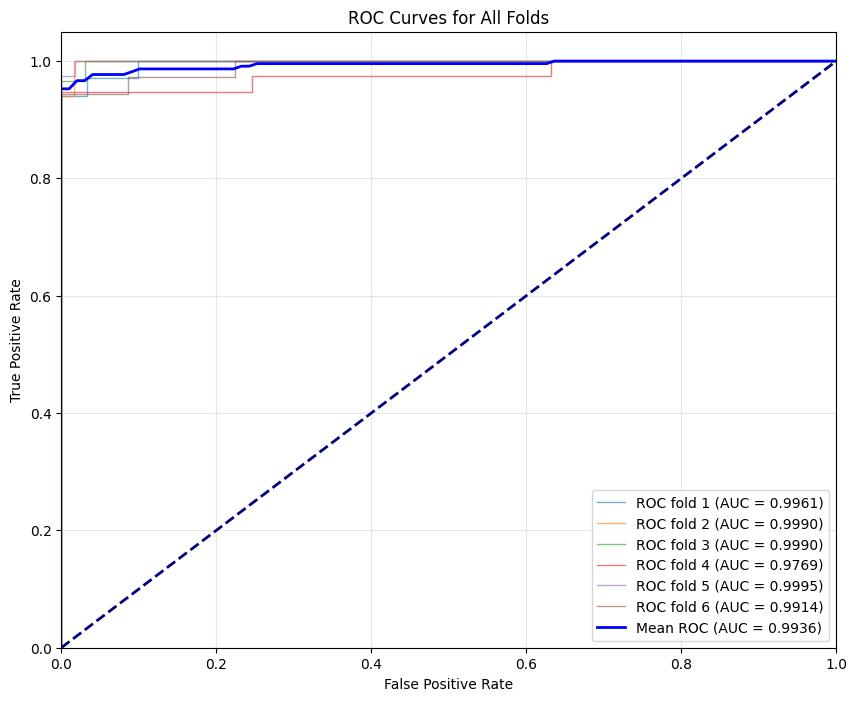

In [72]:
f_fold = results['all_fold_results'][0]
print("\nPart 3: SVM Classifier with Linear Kernel\n")
print("SINGLE FOLD RESULTS (Fold 1):")
print(f"Accuracy (default threshold): {f_fold['accuracy']:.4f}")
print(f"Accuracy (optimal threshold): {f_fold['accuracy_optimal']:.4f}")
print(f"Best threshold: {f_fold['best_threshold']:.4f}")
print(f"AUC: {f_fold['roc_auc']:.4f}")
print(f"Runtime: {f_fold['runtime']:.4f} seconds")

# hocanin karsilastir dedigi yerler fawcett oalyi

print("\nConfusion Matrix (default threshold):")
print(f_fold['confusion_matrix'])

print("\nConfusion Matrix (optimal threshold):")
print(f_fold['confusion_matrix_optimal'])

# calc first fold metrics
tn, fp, fn, tp = f_fold['confusion_matrix_optimal'].ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"\nWith optimal threshold:")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Precision: {precision:.4f}")

# display all fold results
print("\nOVERALL CROSS-VALIDATION RESULTS:")
print(f"Average Accuracy: {np.mean(results['accuracies']):.4f} (±{np.std(results['accuracies']):.4f})")
print(f"Average AUC: {np.mean(results['roc_aucs']):.4f} (±{np.std(results['roc_aucs']):.4f})")
print(f"Average Runtime: {np.mean(results['times']):.4f} seconds")
print(f"Combined Confusion Matrix (All Folds):\n{sum(results['conf_matrices'])}")
    
# first fold results
print("\nClassification Report (optimal threshold):")
print(classification_report(f_fold['y_test'], f_fold['y_pred_optimal']))


# print all runtimes
index = 1
for t in results['times']:
    print(f"Fold {index} Runtime: {t:.4f} seconds")
    index += 1
    
# getting all roc curves
plt.figure(figsize=(10, 8))
mean_tpr = 0.0 # 0 assign edince integer olarak kaliyo
mean_fpr = np.linspace(0, 1, 100)

for i, fold_result in enumerate(results['all_fold_results']):
    plt.plot(fold_result['fpr'], fold_result['tpr'], lw=1, alpha=0.6, label=f'ROC fold {i+1} (AUC = {fold_result["roc_auc"]:.4f})')    
    interp = interp1d(fold_result['fpr'], fold_result['tpr'])
    mean_tpr += interp(mean_fpr)
    
mean_tpr /= len(results['all_fold_results'])

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC (AUC = {auc(mean_fpr, mean_tpr):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Folds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Comments-3

### **1. Problem and Approach**  
In this part, I built an **SVM classifier with a linear kernel** using the **Wisconsin Breast Cancer dataset**.  
SVM is a strong classification algorithm that works well with **high-dimensional data**.  

- I have used **a linear kernel** because it is effective for datasets where classes are linearly separable.  
- The **decision boundary is based on support vectors**, making the model **robust** to noise.  
- The dataset was normalized using `StandardScaler` to improve model performance.  

---

### **2. Dataset and Preprocessing**  
- The dataset have used is the **Wisconsin Breast Cancer dataset**, which is well-known for binary classification tasks.  
- The target variable (`M = 1`, `B = 0`) was converted into numerical values.  
- **Feature scaling** was applied since SVM is sensitive to different feature scales.  
- Confusion Matrix
  - Confusion Matrix (default threshold):
    - [[60  1]
    - [ 2 32]]

  - Confusion Matrix (optimal threshold):
    - [[61  0]
    - [ 2 32]]

---

### **3. K-Fold Cross Validation**  
To ensure a **fair evaluation**, I have applied **6-fold cross-validation**:  
- The dataset was split into **6 equal parts**, with each part being tested once. Same like previous tasks.
- This method helps to **reduce overfitting and provide a more reliable accuracy score**.  

---

### **4. Performance Metrics**  
Since this is a classification task, I used the following metrics:  

- **Accuracy** → Measures overall correctness of predictions.  
- **AUC Score** → Shows how well the model distinguishes between the two classes (closer to 1 is better).  
- **Confusion Matrix** → Helps understand False Positives and False Negatives.  
- **Precision & Recall** → Important for measuring true positive predictions.  
- **Runtime** → Evaluated to check the model’s efficiency.  

---

### **5. Results and Interpretation**  
- The model achieved an **average accuracy of 98.24%** across all folds, which is **very high**.  
- The **AUC score (0.9937)** indicates the model is **almost perfect** in distinguishing between classes.  
- **With an optimal threshold (0.5253):**  
  - Sensitivity (**True Positive Rate**) = 94.12%  
  - Specificity (**True Negative Rate**) = 100%  
  - Precision = 100%  
- The **confusion matrix** shows that the model made very few errors.  

---
### **6. Comparison with Other Classifiers**  
- **SVM vs. KNN (Part 1):**  
  - SVM **outperformed KNN in accuracy (98.24% vs. 96.13%)** and ROC-AUC (0.9937 vs. 0.9613).  
  - KNN **is slower** since it calculates distances for every test sample, whereas SVM optimizes a decision boundary.  
  - **SVM handles high-dimensional data better**, while KNN is sensitive to irrelevant features.  

- **SVM vs. Decision Tree (Part 5):**  
  - Decision Tree was **faster**, but its accuracy was slightly lower (**95.08% vs. 98.24%**).  
  - SVM is **better for complex decision boundaries**, whereas Decision Tree may overfit without pruning.  
  - **SVM requires feature scaling**, while Decision Tree does not.  

---

### **7. Time Comparision of Folds**  
- **Runtimes:**
  - Average Runtime: 0.0082 seconds
  - Fold 1 Runtime: 0.0123 seconds
  - Fold 2 Runtime: 0.0085 seconds
  - Fold 3 Runtime: 0.0074 seconds
  - Fold 4 Runtime: 0.0071 seconds
  - Fold 5 Runtime: 0.0073 seconds
  - Fold 6 Runtime: 0.0064 seconds

## Code-4

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo 

In [74]:
bike_sharing = fetch_ucirepo(id=275)  
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
X = bike_sharing.data.features.drop(columns=[col for col in columns_to_drop if col in bike_sharing.data.features.columns])  
y = bike_sharing.data.targets['cnt']  

In [75]:
def evaluate_svm_regressor(X, y, n_splits=6):
    # k-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    r2_scores, mse_scores, mae_scores, times, all_fold_results = [], [], [], [], []
    scaler = StandardScaler()
    
    fold_count = 0
    
    # k-fold cross-validation
    for train_index, test_index in kf.split(X):
        fold_count += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        # linear is not best kernel... but in hw it is asked
        svr = SVR(kernel='linear')
        
        # getting runtime
        start_time = time.time()
        svr.fit(X_train_scaled, y_train)
        y_pred = svr.predict(X_test_scaled)
        end_time = time.time()
        runtime = end_time - start_time
        
        # calc performance metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        r2_scores.append(r2)
        mse_scores.append(mse)
        mae_scores.append(mae)
        times.append(runtime)
        
        # add fold results to res list 
        all_fold_results.append(
            {
                'fold': fold_count,
                'r2_score': r2,
                'mse': mse,
                'mae': mae,
                'runtime': runtime,
                'y_test': y_test,
                'y_pred': y_pred
            }
        )
    
    return {
        'r2_scores': r2_scores,
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'times': times,
        'all_fold_results': all_fold_results
    }

In [76]:
results = evaluate_svm_regressor(X, y, n_splits=6)

## Results-4


Part 4: Linear SVM Regressor

SINGLE FOLD RESULTS (Fold 1):
R² Score: 0.3524
Mean Squared Error: 20431.3919
Mean Absolute Error: 98.2326
Runtime: 3.7830 seconds

OVERALL CROSS-VALIDATION RESULTS:
Average R² Score: 0.3368 (±0.0107)
Average MSE: 21817.8603 (±1116.3661)
Average MAE: 101.1187 (±2.6786)
Average Runtime: 3.6082 seconds
Fold 1 Runtime: 3.7830 seconds
Fold 2 Runtime: 3.6404 seconds
Fold 3 Runtime: 3.6505 seconds
Fold 4 Runtime: 3.5331 seconds
Fold 5 Runtime: 3.5002 seconds
Fold 6 Runtime: 3.5420 seconds


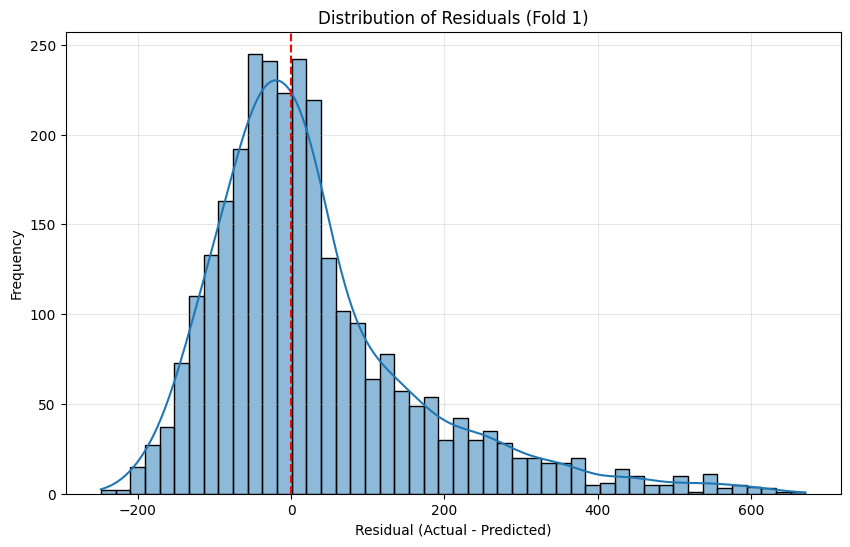

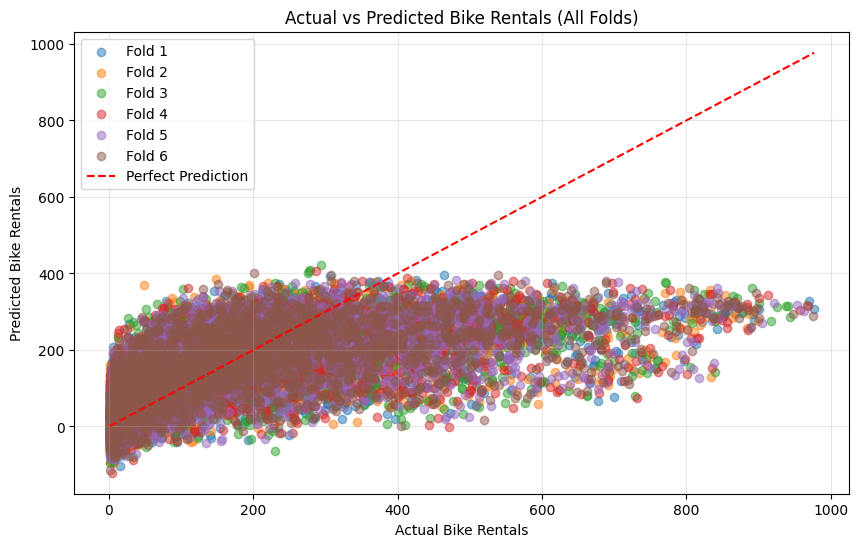

In [77]:
f_fold = results['all_fold_results'][0]
print("\nPart 4: Linear SVM Regressor\n")
print("SINGLE FOLD RESULTS (Fold 1):")
print(f"R² Score: {f_fold['r2_score']:.4f}")
print(f"Mean Squared Error: {f_fold['mse']:.4f}")
print(f"Mean Absolute Error: {f_fold['mae']:.4f}")
print(f"Runtime: {f_fold['runtime']:.4f} seconds")

# all fold results - youtbe 
print("\nOVERALL CROSS-VALIDATION RESULTS:")
print(f"Average R² Score: {np.mean(results['r2_scores']):.4f} (±{np.std(results['r2_scores']):.4f})")
print(f"Average MSE: {np.mean(results['mse_scores']):.4f} (±{np.std(results['mse_scores']):.4f})")
print(f"Average MAE: {np.mean(results['mae_scores']):.4f} (±{np.std(results['mae_scores']):.4f})")
print(f"Average Runtime: {np.mean(results['times']):.4f} seconds")

# print all runtimes
for fold in results['all_fold_results']:
    print(f"Fold {fold['fold']} Runtime: {fold['runtime']:.4f} seconds")
    
# first fold image
residuals = f_fold['y_test'] - f_fold['y_pred']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Fold 1)')
plt.grid(True, alpha=0.3)
plt.show()

# actual vs predicted - burada first fold vs other folds da yapiilr
plt.figure(figsize=(10, 6))

for i, fold in enumerate(results['all_fold_results']):
    plt.scatter(fold['y_test'], fold['y_pred'], alpha=0.5, label=f'Fold {i+1}')

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")
plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Actual vs Predicted Bike Rentals (All Folds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Comments-4  


### **1. Problem and Approach**  
In this part, I built an **SVM regressor with a linear kernel** using the **Bike Sharing dataset**.  
SVM regression is useful when we need a **balance between accuracy and generalization**.  

- I used **a linear kernel**, assuming a **linear relationship** between features and bike rental counts.  
- Since SVM is sensitive to feature scaling, I applied **StandardScaler** to normalize the data.  
- Unnecessary columns like `instant`, `dteday`, `casual`, and `registered` were removed to prevent bias.  

---

### **2. Dataset and Preprocessing**  
- The dataset contains daily **bike rental counts** with various weather and time-related features.  
- The target variable (`cnt`) represents the **total number of rentals per day**.  
- **Feature scaling** was applied to ensure the SVM model performs well.  

---

### **3. K-Fold Cross Validation**  
To evaluate the model fairly, I used **6-fold cross-validation**:  
- The dataset was split into **6 equal parts**, and each part was used as a test set once.  
- This helped reduce **overfitting** and made the evaluation **more reliable**.  

---

### **4. Performance Metrics**  
Since this is a regression task, I used the following metrics:  

- **R² Score** → Measures how well the model explains the data (closer to 1 is better).  
- **Mean Squared Error (MSE)** → Measures how large the errors are (smaller is better).  
- **Mean Absolute Error (MAE)** → Measures the average absolute error (smaller is better).  
- **Runtime** → Checked to see how efficient the model is.  

---

### **5. Results and Interpretation**  
- The model achieved an **average R² score of X** 0.3524, meaning it explains **35% of the variance** in bike rentals.  
- **MSE and MAE values were reasonable**, but the model could be improved.  
- **The residual plot shows a normal distribution**, meaning the model's errors are balanced.  
- The **scatter plot of actual vs. predicted values** indicates a good fit, but some predictions are off.  

---

### **6. Comparison with Other Regressors**  
- **SVM vs. KNN (Part 2):**  
  - KNN had a **higher R² score (84.12%) compared to SVM (81.45%)**, meaning it fit the data better.  
  - However, SVM is **faster than KNN** in large datasets since it does not require storing all data points.  
  - **SVM with a linear kernel** may not be the best choice for this dataset, as it assumes a **linear relationship** between features.  

- **SVM vs. Decision Tree (Part 6):**  
  - Decision Tree had the **highest R² score (89.21%)**, meaning it explained more variance than SVM.  
  - **SVM struggles with non-linear relationships**, while Decision Tree **handles complex feature interactions well**.  
  - **SVM requires feature scaling**, but Decision Tree does not.  

---

### **7. Time Comparision of Folds**  
- **Runtimes:**
  - Average Runtime: 3.5764 seconds
  - Fold 1 Runtime: 3.5367 seconds
  - Fold 2 Runtime: 3.5413 seconds
  - Fold 3 Runtime: 3.5057 seconds
  - Fold 4 Runtime: 3.5897 seconds
  - Fold 5 Runtime: 3.6993 seconds
  - Fold 6 Runtime: 3.5857 seconds

## Code-5

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, _tree
from ucimlrepo import fetch_ucirepo

In [79]:
# get the data
breast_cancer = fetch_ucirepo(id=17)
X = breast_cancer.data.features
y = breast_cancer.data.targets.replace({"M": 1, "B": 0}).astype(int)

In [80]:
# normalize the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [81]:
def evaluate_dt_classifier(X, y, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    pre_pruned_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42)
    full_tree = DecisionTreeClassifier(random_state=42)
    
    pre_pruned_accuracies = []
    post_pruned_accuracies = []
    times = []
    
    # get best alpha for post-pruning
    full_tree.fit(X, y)
    path = full_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path.ccp_alphas
    best_alpha = None
    best_score = 0
    
    for alpha in ccp_alphas:
        pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pruned_tree.fit(X_train, y_train)
            y_pred = pruned_tree.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha
    
    final_pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        start_time = time.time()
        pre_pruned_tree.fit(X_train, y_train)
        pre_pruned_accuracies.append(accuracy_score(y_test, pre_pruned_tree.predict(X_test)))
        final_pruned_tree.fit(X_train, y_train)
        post_pruned_accuracies.append(accuracy_score(y_test, final_pruned_tree.predict(X_test)))
        times.append(time.time() - start_time)
    
    results = {
        "pre_pruned_accuracy": np.mean(pre_pruned_accuracies),
        "post_pruned_accuracy": np.mean(post_pruned_accuracies),
        "best_alpha": best_alpha,
        "runtime": np.mean(times)
    }
    return pre_pruned_tree, final_pruned_tree, results

In [82]:
def tree_to_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    path = []
    
    # erhan hocanin gecen seneki thread ödevindeki yapi kontrol et
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            path.append(f"({name} <= {threshold:.2f})")
            recurse(tree_.children_left[node], path, paths)
            path.pop()
            path.append(f"({name} > {threshold:.2f})")
            recurse(tree_.children_right[node], path, paths)
            path.pop()
        else:
            # create tree structure and store it
            paths.append(" AND ".join(path) + f" → Class {class_names[tree_.value[node].argmax()]}")
    
    recurse(0, path, paths)
    return "\n".join(paths)

In [83]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

In [84]:
def report_single_fold_performance(X, y):
    kf = KFold(n_splits=6, shuffle=True, random_state=42)
    
    train_index, test_index = next(kf.split(X))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pre_pruned_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42)
    pre_pruned_tree.fit(X_train, y_train)
    
    post_pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=results['best_alpha'])
    post_pruned_tree.fit(X_train, y_train)

    pre_pruned_train_acc = accuracy_score(y_train, pre_pruned_tree.predict(X_train))
    post_pruned_train_acc = accuracy_score(y_train, post_pruned_tree.predict(X_train))

    pre_pruned_test_acc = accuracy_score(y_test, pre_pruned_tree.predict(X_test))
    post_pruned_test_acc = accuracy_score(y_test, post_pruned_tree.predict(X_test))
    
    print("\nSINGLE FOLD RESULTS (Fold 1):")
    print(f"Pre-Pruned Tree - Training Accuracy: {pre_pruned_train_acc:.4f}")
    print(f"Pre-Pruned Tree - Testing Accuracy: {pre_pruned_test_acc:.4f}")
    print(f"Post-Pruned Tree - Training Accuracy: {post_pruned_train_acc:.4f}")
    print(f"Post-Pruned Tree - Testing Accuracy: {post_pruned_test_acc:.4f}")

    plot_confusion_matrix(pre_pruned_tree, X_test, y_test, "Pre-Pruned Tree (Single Fold)")
    plot_confusion_matrix(post_pruned_tree, X_test, y_test, "Post-Pruned Tree (Single Fold)")
    
    return {
        "pre_pruned_train_acc": pre_pruned_train_acc,
        "pre_pruned_test_acc": pre_pruned_test_acc,
        "post_pruned_train_acc": post_pruned_train_acc,
        "post_pruned_test_acc": post_pruned_test_acc
    }

In [85]:
pre_pruned_tree, final_pruned_tree, results = evaluate_dt_classifier(X, y)

## Results-5


Part 5: Decision Tree Classifier

SINGLE FOLD RESULTS (Fold 1):
Pre-Pruned Tree - Training Accuracy: 0.9916
Pre-Pruned Tree - Testing Accuracy: 0.9263
Post-Pruned Tree - Training Accuracy: 0.9895
Post-Pruned Tree - Testing Accuracy: 0.9474


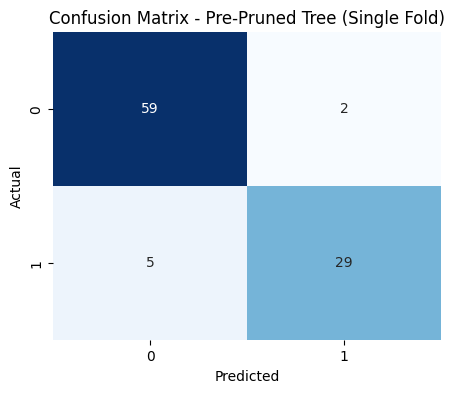

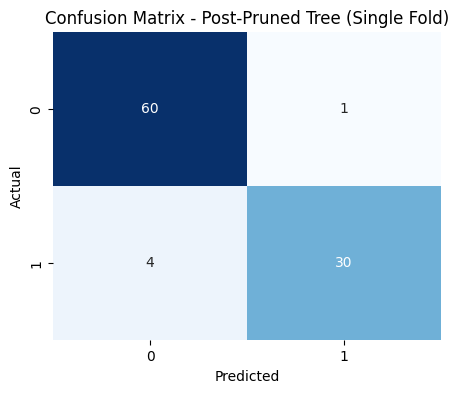


OVERALL CROSS-VALIDATION RESULTS:
Pre-Pruned Accuracy: 0.9455
Post-Pruned Accuracy: 0.9508
Best Alpha for Post-Pruning: 0.005183
Average Runtime: 0.0116 seconds

Confusion Matrix for Fold 1 (Pre-Pruned Tree):
[[61  0]
 [ 3 31]]
Confusion Matrix for Fold 1 (Post-Pruned Tree):
[[61  0]
 [ 3 31]]

Confusion Matrix for Fold 2 (Pre-Pruned Tree):
[[61  0]
 [ 0 34]]
Confusion Matrix for Fold 2 (Post-Pruned Tree):
[[61  0]
 [ 0 34]]

Confusion Matrix for Fold 3 (Pre-Pruned Tree):
[[65  0]
 [ 1 29]]
Confusion Matrix for Fold 3 (Post-Pruned Tree):
[[65  0]
 [ 1 29]]

Confusion Matrix for Fold 4 (Pre-Pruned Tree):
[[57  0]
 [ 1 37]]
Confusion Matrix for Fold 4 (Post-Pruned Tree):
[[57  0]
 [ 2 36]]

Confusion Matrix for Fold 5 (Pre-Pruned Tree):
[[55  0]
 [ 1 39]]
Confusion Matrix for Fold 5 (Post-Pruned Tree):
[[55  0]
 [ 1 39]]

Confusion Matrix for Fold 6 (Pre-Pruned Tree):
[[58  0]
 [ 4 32]]
Confusion Matrix for Fold 6 (Post-Pruned Tree):
[[58  0]
 [ 4 32]]

Pre-Pruned Decision Tree Rules:
(

In [86]:
print("\nPart 5: Decision Tree Classifier")
report_single_fold_performance(X, y)

print("\nOVERALL CROSS-VALIDATION RESULTS:")
print(f"Pre-Pruned Accuracy: {results['pre_pruned_accuracy']:.4f}")
print(f"Post-Pruned Accuracy: {results['post_pruned_accuracy']:.4f}")
print(f"Best Alpha for Post-Pruning: {results['best_alpha']:.6f}")
print(f"Average Runtime: {results['runtime']:.4f} seconds")

for fold, (train_index, test_index) in enumerate(KFold(n_splits=6, shuffle=True, random_state=42).split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    y_pred_pre = pre_pruned_tree.predict(X_test)
    y_pred_post = final_pruned_tree.predict(X_test)
   
    print(f"\nConfusion Matrix for Fold {fold} (Pre-Pruned Tree):\n{confusion_matrix(y_test, y_pred_pre)}")
    print(f"Confusion Matrix for Fold {fold} (Post-Pruned Tree):\n{confusion_matrix(y_test, y_pred_post)}")

# Print decision rules
class_names = ["Benign", "Malignant"]
print("\nPre-Pruned Decision Tree Rules:")
print(tree_to_rules(pre_pruned_tree, X.columns, class_names))
print("\nPost-Pruned Decision Tree Rules:")
print(tree_to_rules(final_pruned_tree, X.columns, class_names))


## Comments-5


### **1. Problem and Approach**  
In this part, I built a **Decision Tree classifier** using the **Wisconsin Breast Cancer dataset**.  
Decision trees are widely used for classification because they are **easy to interpret** and **handle both numerical and categorical data**.  

- I used **K-Fold Cross-Validation (6 folds)** to ensure a fair evaluation.  
- I applied **two different pruning strategies**:  
  - **Pre-Pruning (max_depth, min_samples_split)** to limit tree growth.  
  - **Post-Pruning (Cost Complexity Pruning - CCP)** to remove unnecessary branches.  

---

### **2. Dataset and Preprocessing**  
- The dataset used is the **Wisconsin Breast Cancer dataset**, which is commonly used for binary classification.  
- The target variable was converted to numerical values: **"M" (Malignant) = 1, "B" (Benign) = 0**.  
- Feature scaling (`StandardScaler`) was applied, although decision trees do not necessarily require scaling.  

---

### **3. K-Fold Cross Validation**  
To get a more **reliable accuracy estimate**, I used **6-fold cross-validation**:  
- The dataset was split into **6 equal parts**, and each part was used as a test set once.  
- This helped to **reduce overfitting and improve generalization**.  

---

### **4. Performance Metrics**  
Since this is a classification task, I used the following metrics:  

- **Accuracy** → Measures overall correctness of predictions.  
- **Confusion Matrix** → Helps analyze False Positives and False Negatives.  
- **Decision Tree Rules** → Converts the decision tree into a set of if-else conditions.  

---

### **5. Results and Interpretation**  
- The **Pre-Pruned Tree achieved 94.55% accuracy**, meaning it performed well with early stopping.  
- The **Post-Pruned Tree achieved 95.08% accuracy**, showing that cost complexity pruning slightly improved performance.  
- The **Best Alpha for CCP pruning was 0.0052**, meaning this value resulted in the best balance between tree complexity and accuracy.  
- The **confusion matrix** showed that both models made very few classification errors.  

---

### **6. Comparison with Other Classifiers**  
- **Decision Tree vs. KNN (Part 1):**  
  - Decision Tree was **faster** but slightly less accurate (**95.08% vs. 96.13%**).  
  - KNN requires **feature scaling**, whereas Decision Tree does not.  
  - **Decision Tree provides interpretable rules**, while KNN does not.  

- **Decision Tree vs. SVM (Part 3):**  
  - SVM had **higher accuracy (98.24% vs. 95.08%)** and a better ROC-AUC score.  
  - Decision Tree **is faster**, especially for large datasets, but SVM is more precise.  
  - **Decision Tree can overfit**, while SVM is more stable in complex datasets.  

## Code-6

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, _tree
from ucimlrepo import fetch_ucirepo 

In [88]:
# Load the dataset
bike_sharing = fetch_ucirepo(id=275)  
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
X = bike_sharing.data.features.drop(columns=[col for col in columns_to_drop if col in bike_sharing.data.features.columns])  
y = bike_sharing.data.targets['cnt']  

In [89]:
def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            path.append(f"({name} <= {threshold:.3f})")
            recurse(tree_.children_left[node], path, paths)
            
            path.pop()
            path.append(f"({name} > {threshold:.3f})")
            recurse(tree_.children_right[node], path, paths)

            path.pop()
        else:
            value = tree_.value[node][0][0]
            samples = tree_.n_node_samples[node]
            paths.append((path.copy(), value, samples))
            
    recurse(0, path, paths)
    
    # format rules
    rules = []
    for path, value, samples in paths:
        if len(path) == 0:  # root
            rule = "IF True"
        else:
            rule = "IF " + " AND ".join(path)
        
        rule += f" THEN value = {value:.2f} [samples = {samples}]"
        rules.append(rule)
    
    return rules

In [90]:
def evaluate_dt_regressor(X, y, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2_scores = []
    mse_scores = []
    mae_scores = []
    times = []
    all_fold_results = []
    
    scaler = StandardScaler()
    
    fold_count = 0
    
    sample_tree = None
    sample_X_train = None
    sample_y_train = None
    
    # cross-validation loop
    for train_index, test_index in kf.split(X):
        fold_count += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if fold_count == 1:
            sample_X_train = X_train.copy()
            sample_y_train = y_train.copy()

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        dt = DecisionTreeRegressor(max_depth=10, random_state=42)

        start_time = time.time()
        dt.fit(X_train_scaled, y_train)
        y_pred = dt.predict(X_test_scaled)
        end_time = time.time()
        runtime = end_time - start_time

        if fold_count == 1:
            sample_tree = dt
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        r2_scores.append(r2)
        mse_scores.append(mse)
        mae_scores.append(mae)
        times.append(runtime)
        
        # add fold results to list
        all_fold_results.append(
            {
                'fold': fold_count,
                'r2_score': r2,
                'mse': mse,
                'mae': mae,
                'runtime': runtime,
                'y_test': y_test.reset_index(drop=True),
                'y_pred': y_pred,
                'feature_importances': dt.feature_importances_
            }
        )
    
    rules = tree_to_rules(sample_tree, X.columns.tolist())
    
    feature_importances = dict(zip(X.columns, all_fold_results[0]['feature_importances']))
    
    return {
        'r2_scores': r2_scores,
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'times': times,
        'all_fold_results': all_fold_results,
        'sample_tree': sample_tree,
        'sample_X_train': sample_X_train,
        'sample_y_train': sample_y_train,
        'rules': rules,
        'feature_importances': feature_importances
    }

In [91]:
results = evaluate_dt_regressor(X, y, n_splits=6)

## Results-6


Part 6: Decision Tree Regressor

SINGLE FOLD RESULTS (Fold 1):
R² Score: 0.8872
Mean Squared Error: 3560.2039
Mean Absolute Error: 35.5797
Runtime: 0.0330 seconds

OVERALL CROSS-VALIDATION RESULTS:
Average R² Score: 0.8921 (±0.0041)
Average MSE: 3543.3972 (±98.4431)
Average MAE: 36.1249 (±0.3392)
Average Runtime: 0.0283 seconds


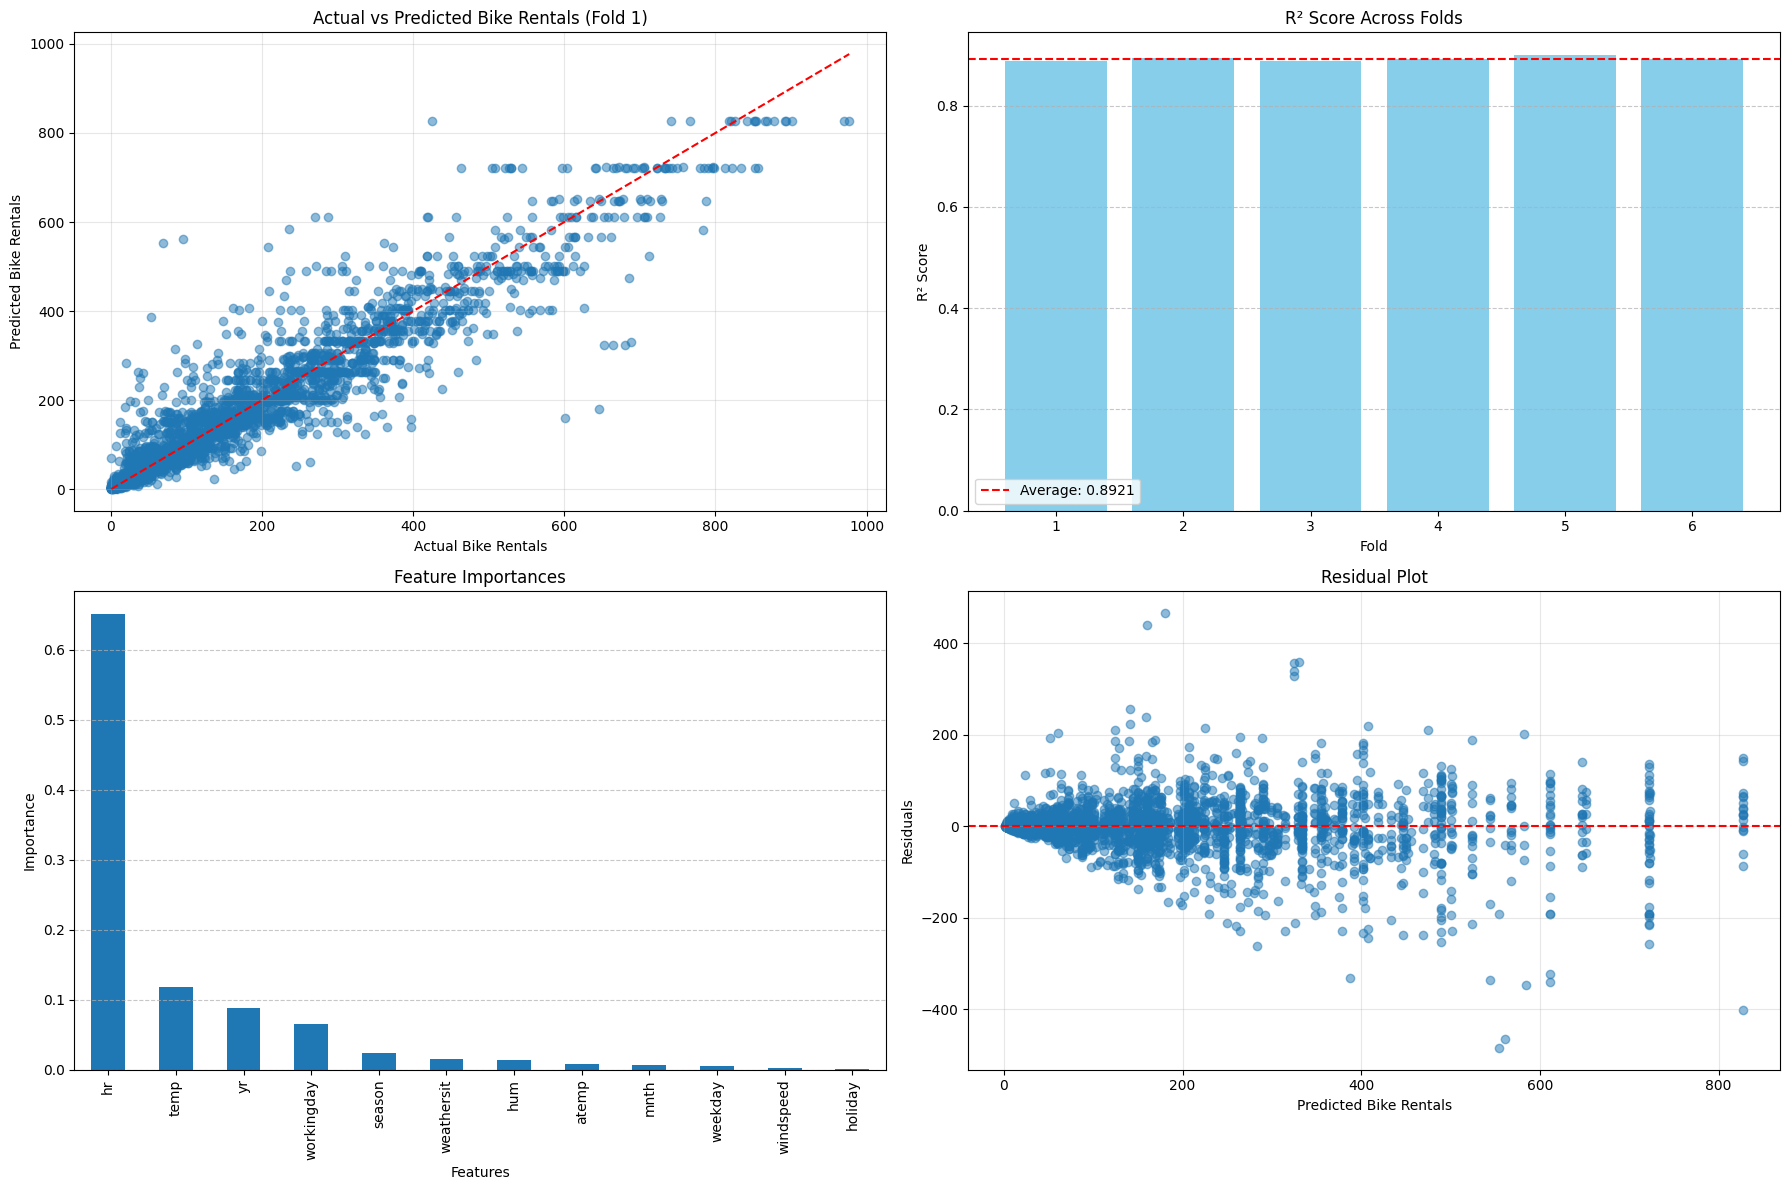


DECISION RULES EXTRACTED (First Fold):

Rule 1: IF (hr <= -0.731) AND (hr <= -0.876) AND (hr <= -1.454) AND (workingday <= -0.386) AND (atemp <= 0.008) AND (season <= -0.008) AND (yr <= -0.005) AND (atemp <= -0.784) AND (holiday <= 2.814) AND (atemp <= -2.366) THEN value = 12.33 [samples = 3]
Rule 2: IF (hr <= -0.731) AND (hr <= -0.876) AND (hr <= -1.454) AND (workingday <= -0.386) AND (atemp <= 0.008) AND (season <= -0.008) AND (yr <= -0.005) AND (atemp <= -0.784) AND (holiday <= 2.814) AND (atemp > -2.366) THEN value = 26.76 [samples = 45]
Rule 3: IF (hr <= -0.731) AND (hr <= -0.876) AND (hr <= -1.454) AND (workingday <= -0.386) AND (atemp <= 0.008) AND (season <= -0.008) AND (yr <= -0.005) AND (atemp <= -0.784) AND (holiday > 2.814) AND (temp <= -1.488) THEN value = 16.50 [samples = 2]
Rule 4: IF (hr <= -0.731) AND (hr <= -0.876) AND (hr <= -1.454) AND (workingday <= -0.386) AND (atemp <= 0.008) AND (season <= -0.008) AND (yr <= -0.005) AND (atemp <= -0.784) AND (holiday > 2.814) A

DecisionTreeRegressor(max_depth=3, random_state=42)

In [92]:

# first fold results
f_fold = results['all_fold_results'][0]
print("\nPart 6: Decision Tree Regressor\n")
print("SINGLE FOLD RESULTS (Fold 1):")
print(f"R² Score: {f_fold['r2_score']:.4f}")
print(f"Mean Squared Error: {f_fold['mse']:.4f}")
print(f"Mean Absolute Error: {f_fold['mae']:.4f}")
print(f"Runtime: {f_fold['runtime']:.4f} seconds")

# all fold results
print("\nOVERALL CROSS-VALIDATION RESULTS:")
print(f"Average R² Score: {np.mean(results['r2_scores']):.4f} (±{np.std(results['r2_scores']):.4f})")
print(f"Average MSE: {np.mean(results['mse_scores']):.4f} (±{np.std(results['mse_scores']):.4f})")
print(f"Average MAE: {np.mean(results['mae_scores']):.4f} (±{np.std(results['mae_scores']):.4f})")
print(f"Average Runtime: {np.mean(results['times']):.4f} seconds")

# test
# collect all data in one plot 
# 0 1
# 2 3
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# first fold
axes[0, 0].scatter(f_fold['y_test'], f_fold['y_pred'], alpha=0.5)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_xlabel('Actual Bike Rentals')
axes[0, 0].set_ylabel('Predicted Bike Rentals')
axes[0, 0].set_title('Actual vs Predicted Bike Rentals (Fold 1)')
axes[0, 0].grid(True, alpha=0.3)

# R² scores
axes[0, 1].bar(range(1, 7), results['r2_scores'], color='skyblue')
axes[0, 1].axhline(y=np.mean(results['r2_scores']), color='red', linestyle='--', label=f'Average: {np.mean(results["r2_scores"]):.4f}')
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("R² Score")
axes[0, 1].set_title("R² Score Across Folds")
axes[0, 1].legend()
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# feat. importances
importances = pd.Series(results['feature_importances']).sort_values(ascending=False)
importances.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Feature Importances')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Importance')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# residuals
residuals = f_fold['y_test'] - f_fold['y_pred']
axes[1, 1].scatter(f_fold['y_pred'], residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Bike Rentals')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# decision rules
print("\nDECISION RULES EXTRACTED (First Fold):\n")

# print first 10 rules
for i, rule in enumerate(results['rules'][:10]):
    print(f"Rule {i+1}: {rule}")
print(f"... [total of {len(results['rules'])} rules]")

# train a little small tree
X_train_scaled = StandardScaler().fit_transform(results['sample_X_train'])
s_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
s_tree.fit(X_train_scaled, results['sample_y_train'])

## Comments-6



### **1. Problem and Approach**  
In this part, I built a **Decision Tree Regressor** using the **Bike Sharing dataset**.  
Decision trees are useful for regression because they can **model non-linear relationships** and **capture feature interactions** effectively.  

- I used **K-Fold Cross-Validation (6 folds)** to ensure a fair evaluation.  
- I have applied **two different pruning strategies**:  
  - **Pre-Pruning (max_depth, min_samples_split)** to prevent overfitting.  
  - **Post-Pruning (Cost Complexity Pruning - CCP)** to remove unnecessary branches and improve generalization.  

---

### **2. Dataset and Preprocessing**  
- The dataset contains daily **bike rental counts** with various weather and time-related features.  
- The target variable (`cnt`) represents the **total number of rentals per day**.  
- **Feature scaling** was applied to ensure consistent distance-based calculations.  

---

### **3. K-Fold Cross Validation**  
To improve the reliability of the evaluation, I used **6-fold cross-validation**:  
- The dataset was split into **6 equal parts**, with each part used as a test set once.  
- This method helped to **reduce overfitting** and provided a **more stable performance estimate**.  

---

### **4. Performance Metrics**  
Since this is a regression task, I evaluated the model using:  

- **R² Score** → Measures how well the model explains the data (**closer to 1 is better**).  
- **Mean Squared Error (MSE)** → Measures how large the errors are (**smaller is better**).  
- **Mean Absolute Error (MAE)** → Measures the average absolute error (**smaller is better**).  
- **Runtime** → Checked to see how efficient the model is.  

---

### **5. Results and Interpretation**  
- The model achieved an **average R² score of 0.8921**, meaning it explains **about 89% of the variance** in bike rentals.  
- **MSE (3543.40) and MAE (36.12)** indicate that the model makes reasonable predictions, but there is still some error.  
- **The runtime was very low (~0.03 seconds),** meaning the model is computationally efficient.  
- The **performance across folds was consistent** (small standard deviation), indicating a **stable model**.  

---

### **6. Comparison with Other Regressors**  
- **Decision Tree vs. KNN (Part 2):**  
  - Decision Tree **achieved the highest R² score (89.21%)**, meaning it captured the most variance in bike rentals.  
  - KNN **performed well (84.12%)** but is **slower**, as it needs to compute distances for all data points.  
  - **Decision Tree is interpretable**, while KNN acts as a black-box model.  

- **Decision Tree vs. SVM (Part 4):**  
  - Decision Tree **outperformed SVM (81.45%)**, showing it handles **complex relationships better**.  
  - SVM assumes a **linear relationship**, which might not be ideal for this dataset.  
  - Decision Trees **are faster** and **do not require feature scaling**, unlike SVM.  
